In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from scipy.optimize import curve_fit
import aliensims as dy


In [2]:
hdu = fits.open('008110757_dvt.fits')
print("number of TCEs:", len(hdu)-2)

number of TCEs: 1


In [15]:
print(hdu[1].header)

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   44 / length of first array dimension                NAXIS2  =                71427 / length of second array dimension               PCOUNT  =                    0 / group parameter count (not used)               GCOUNT  =                    1 / group count (not used)                         TFIELDS =                   10 / number of table fields                         TTYPE1  = 'TIME    '           / column title: data time stamps                 TFORM1  = 'D       '           / column format: 64-bit floating point           TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          TDISP1  = 'D14.7   '           / column display format                          TTYPE2  = 'TIMECORR'           / column 

In [3]:
#algol model:
def pl(z,p):

    if(1+p <z):
        return(0)

    elif(1-p<z and z<1+p):
        k0 = np.arccos((p**2 + z**2 - 1)/(2*p*z))
        k1 = np.arccos(( -p**2 + z**2 + 1)/(2*z))
        y = (1/np.pi)*(p**2*k0 + k1 - np.sqrt((4*z**2 - (1+z**2 -p**2)**2)/4))
        return(y)

    elif(z<1-p):
        return(p**2)

    elif(z<p-1):
        return(1)


    
    

def plar(ph,p,rorb):
    znp = np.abs(rorb*np.sin(ph*np.pi))
    op =[]
    for z in znp:
        if(1+p <z):
            op.append(0)

        elif(1-p<z and z<1+p):
            k0 = np.arccos((p**2 + z**2 - 1)/(2*p*z))
            k1 = np.arccos(( -p**2 + z**2 + 1)/(2*z))
            y = (1/np.pi)*(p**2*k0 + k1 - np.sqrt((4*z**2 - (1+z**2 -p**2)**2)/4))
            op.append(y)

        elif(z<1-p):
            op.append(p**2)

        elif(z<p-1):
            op.append(1)
    return(-np.array(op))

    #else: return(0)

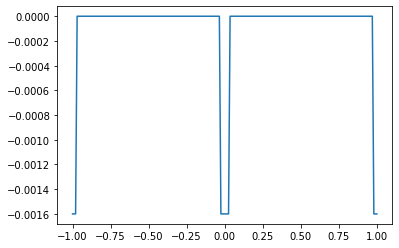

In [4]:
z = np.linspace(-1,1,200)
plt.plot(z, plar(z,0.04,11.71))

In [5]:
flux = []
phase = []
model = []
for ph, fl, ml in zip(hdu[1].data['PHASE'],hdu[1].data['LC_DETREND'],hdu[1].data['MODEL_WHITE']):
    if not np.isnan(fl):
        flux.append(fl)
        phase.append(ph)
        model.append(ml)
df = pd.DataFrame(list(zip(phase, flux, model)),columns=['phase', 'flux', 'model'])
df=df.sort_values('phase',axis=0,ascending='True')
print(len(df))

3279


In [6]:
kernel = np.ones(5)/5
popt2, pcov2 = curve_fit(plar, np.array(df['phase'])[:1600], np.convolve(np.array(df['flux']),kernel, mode='same')[:1600], 
    bounds=([0,1.00001], [0.5,np.inf]))

In [7]:
print(np.round(popt2,5))
print(np.array(df['phase'])[1600])

[ 0.03554 13.45911]
0.12457509


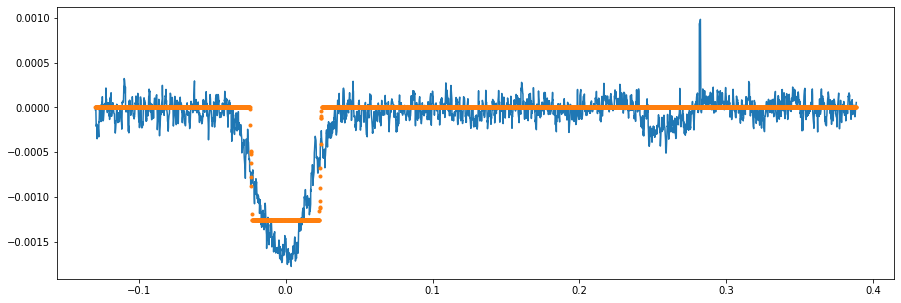

In [8]:
#small interval, not well observed...
#bad news is ... that it may be an eclipsing binary.
#good news is ... the orbit is actually pretty eccentric... so hurray there.
#
plt.figure(figsize=(15,5))
time = hdu[1].data['TIME']
phase = hdu[1].data['PHASE']
kernel = np.ones(5)/5
plt.plot(np.array(df['phase']),np.convolve(np.array(df['flux']), kernel,mode='same'))
#plt.plot(df['phase'], np.convolve(df['model'], kernel,mode='same'), ls='None', marker='.')
plt.plot(np.array(df['phase']), plar(np.array(df['phase']), 0.03554, 13.45911), ls='None', marker='.')
#plt.xlim(0.2,0.3)
#plt.ylim(-0.0008,0.0005)
#plt.xlim(407,412)


In [151]:
#trying out a simulation
sim = dy.Simulator(1, 20000, 200, 0.1*np.pi, 2*0.3975, 0.2650)
meg = dy.Megastructure(13.45, True, 0.035, ecc=0.377, per_off=np.pi/2)
sim.add_megs(meg)

sim2 = dy.Simulator(1, 20000, 200, 0.1*np.pi, 2*0.3975, 0.2650)
meg2 = dy.Megastructure(13.45, True, 0.035, ecc=0.377, per_off=np.pi/2, isrot=True)
sim2.add_megs(meg2)



In [152]:
netlc=[]
for i in range(10):
    road, ph, lc = sim.simulate_transit()
    netlc.append(lc)
    sim.initialize()

netlc2=[]
for i in range(2):
    road2, ph2, lc2 = sim.simulate_transit()
    netlc2.append(lc)
    sim2.initialize()

lc = np.mean(np.array(netlc), axis=0)
lc2 = np.mean(np.array(netlc2), axis=0)


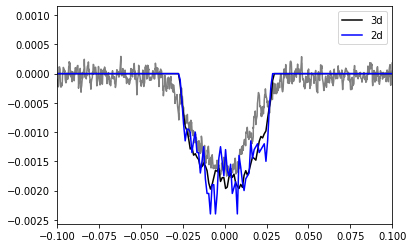

In [155]:

plt.plot(np.array(df['phase']),np.convolve(np.array(df['flux']), kernel,mode='same'), color='gray')
plt.plot(ph/np.pi,np.array(lc)-1, color='black', label='3d')
plt.plot(ph2/np.pi,np.array(lc2)-1, color='blue', label='2d')
plt.legend()
plt.xlim(-0.1,0.1)
print()